In [1]:
import os
os.chdir('/rds/general/user/cb1319/home/GEOM3D/Geom3D/')

In [3]:
from geom3d.utils import database_utils
from geom3d.utils.config_utils import read_config
from pathlib import Path

df_path = Path(
    "/rds/general/user/cb1319/home/GEOM3D/STK_path/", "data/output/Full_dataset/", "df_total_subset_16_11_23.csv"
)
df_precursors_path = Path(
    "/rds/general/user/cb1319/home/GEOM3D/STK_path/",
    "data/output/Prescursor_data/",
    "calculation_data_precursor_071123_clean.pkl",
)
df_total, df_precursors = database_utils.load_data_from_file(
    df_path, df_precursors_path
)

X_frag_mol = df_precursors['mol_opt_2'].values
X_frag_smiles = df_precursors['smiles'].values

# see all the columns in the dataframe
print(df_precursors.columns)


Index(['InChIKey', 'Atom_num', 'HOMO (eV)', 'LUMO (eV)', 'HOMO_LUMO_GAP (eV)',
       'IP (eV)', 'EA (eV)', 'total energy (eV) vipea',
       'First excited state Energy (eV)', 'First excited osc', 'mol_opt_2',
       'mol_opt', 'mol_prel', 'rdkit_descriptors', 'smiles',
       'Excited state Energy (eV)', 'Excited state Osc',
       '1 Excited state Energy (eV)', '1 Excited state Osc',
       '2 Excited state Energy (eV)', '2 Excited state Osc',
       '3 Excited state Energy (eV)', '3 Excited state Osc',
       '4 Excited state Energy (eV)', '4 Excited state Osc',
       '5 Excited state Energy (eV)', '5 Excited state Osc', 'IP_EA_Gap (eV)',
       'TSNE_1d', 'pca0', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6',
       'pca7', 'pca8', 'pca9'],
      dtype='object')


In [4]:
X_InChIKey = df_precursors['InChIKey'].values

df_precursors[['InChIKey']]

,InChIKey
0,ULRLMMWHCRPTDR-UHFFFAOYSA-N
1,KYORXLIHDAZXPK-UHFFFAOYSA-N
2,AMGZARGPNNDZNG-UHFFFAOYSA-N
3,UVCFYBOLMFIWGF-FPYGCLRLSA-N
4,PQZAHLJJGPAGBD-OQFOIZHKSA-N
...,...
307,MRBCQJMEGDDUNN-WMZJFQQLSA-N
308,ITWOUVVCPPUABP-WCIBSUBMSA-N
309,BNVUEFDNDBLDLM-UHFFFAOYSA-N
310,BBVSASGXSWONDF-UHFFFAOYSA-N


In [5]:
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from geom3d.utils import database_utils

print("Number of molecules:", len(X_frag_mol))

# Function to generate Morgan fingerprints
def generate_morgan_fingerprints(molecules, radius=2, n_bits=2048):
    fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits) for mol in molecules]
    return fingerprints

# Function to generate ECFP fingerprints
def generate_ecfp_fingerprints(molecules, radius=2, n_bits=2048):
    fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits) for mol in molecules]
    return fingerprints

# Function to calculate Tanimoto similarity between fingerprints
def calculate_tanimoto_similarity(fingerprint1, fingerprint2):
    return DataStructs.TanimotoSimilarity(fingerprint1, fingerprint2)


# Generate Morgan fingerprints for the dataset
morgan_fingerprints = generate_morgan_fingerprints(X_frag_mol)

# Generate ECFP fingerprints for the dataset
ecfp_fingerprints = generate_ecfp_fingerprints(X_frag_mol)

# Calculate Tanimoto similarity between Morgan fingerprints
print("Tanimoto similarity (Morgan):")
for i in range(len(X_frag_mol)):
    for j in range(i + 1, len(X_frag_mol)):
        tanimoto_sim = calculate_tanimoto_similarity(morgan_fingerprints[i], morgan_fingerprints[j])

# Calculate Tanimoto similarity between ECFP fingerprints
print("\nTanimoto similarity (ECFP):")
for i in range(len(X_frag_mol)):
    for j in range(i + 1, len(X_frag_mol)):
        tanimoto_sim = calculate_tanimoto_similarity(ecfp_fingerprints[i], ecfp_fingerprints[j])



Number of molecules: 310
Tanimoto similarity (Morgan):

Tanimoto similarity (ECFP):


In [6]:
%matplotlib inline

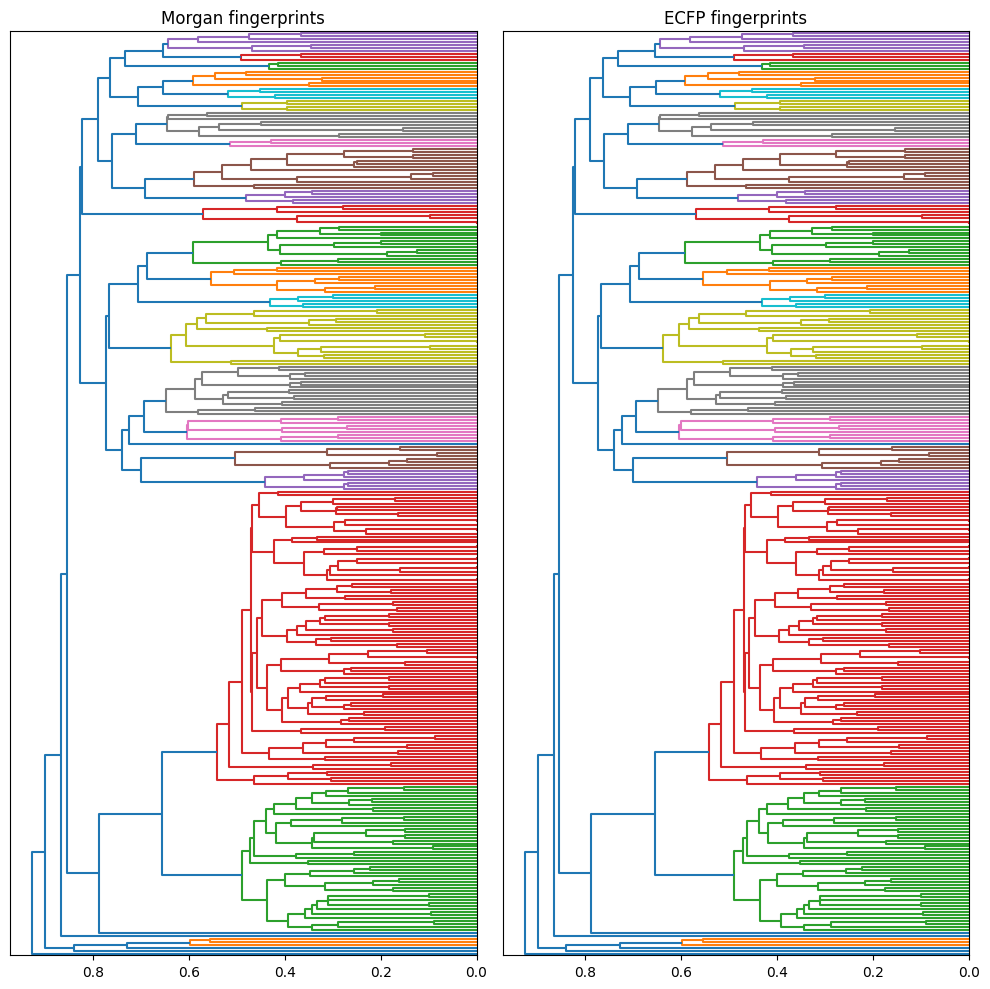

In [7]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Combine Morgan and ECFP fingerprints for clustering
morgan_fingerprints = [list(morgan_fingerprints[i]) for i in range(len(X_frag_mol))]
ecfp_fingerprints = [list(ecfp_fingerprints[i]) for i in range(len(X_frag_mol))]

# Calculate the linkage matrix for hierarchical clustering
morgan_matrix = linkage(morgan_fingerprints, method='average', metric='jaccard')
ecfp_matrix = linkage(ecfp_fingerprints, method='average', metric='jaccard')


# Plot the dendrograms next to eachother
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Morgan fingerprints")
dendrogram(morgan_matrix, ax=ax1, labels=X_frag_smiles, orientation='left')

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("ECFP fingerprints")
dendrogram(ecfp_matrix, ax=ax2, labels=X_frag_smiles, orientation='left')

plt.tight_layout()
plt.show()



In [45]:
from scipy.cluster.hierarchy import fcluster
import numpy as np

# Cut the dendrogram to obtain clusters
threshold = 0.55  # Adjust the threshold based on the dendrogram
clusters_morgan = fcluster(morgan_matrix, threshold, criterion='distance')
clusters_ecfp = fcluster(ecfp_matrix, threshold, criterion='distance')

#number of molecules in each cluster
unique, counts = np.unique(clusters_morgan, return_counts=True)
dict(zip(unique, counts))
print("Number of molecules in each cluster for morgan fp:", dict(zip(unique, counts)))

unique_2, counts_2 = np.unique(clusters_ecfp, return_counts=True)
dict(zip(unique_2, counts_2))
print("Number of molecules in each cluster for ecfp fp:", dict(zip(unique, counts)))




Number of molecules in each cluster for morgan fp: {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 49, 7: 99, 8: 1, 9: 7, 10: 8, 11: 3, 12: 3, 13: 3, 14: 2, 15: 1, 16: 6, 17: 3, 18: 5, 19: 1, 20: 2, 21: 9, 22: 2, 23: 3, 24: 3, 25: 5, 26: 6, 27: 3, 28: 3, 29: 11, 30: 4, 31: 3, 32: 5, 33: 2, 34: 12, 35: 3, 36: 2, 37: 4, 38: 1, 39: 1, 40: 1, 41: 4, 42: 4, 43: 2, 44: 4, 45: 3, 46: 3, 47: 3, 48: 3, 49: 1, 50: 1, 51: 1}
Number of molecules in each cluster for ecfp fp: {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 49, 7: 99, 8: 1, 9: 7, 10: 8, 11: 3, 12: 3, 13: 3, 14: 2, 15: 1, 16: 6, 17: 3, 18: 5, 19: 1, 20: 2, 21: 9, 22: 2, 23: 3, 24: 3, 25: 5, 26: 6, 27: 3, 28: 3, 29: 11, 30: 4, 31: 3, 32: 5, 33: 2, 34: 12, 35: 3, 36: 2, 37: 4, 38: 1, 39: 1, 40: 1, 41: 4, 42: 4, 43: 2, 44: 4, 45: 3, 46: 3, 47: 3, 48: 3, 49: 1, 50: 1, 51: 1}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


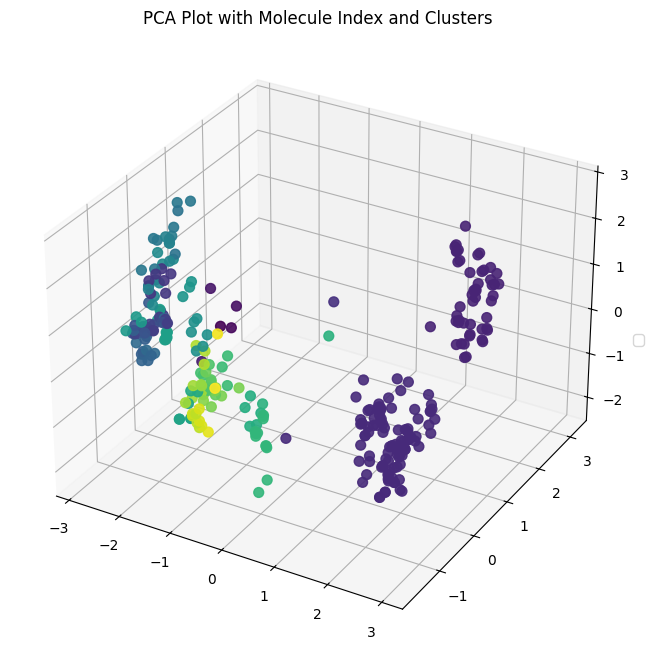

In [49]:
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Apply PCA to reduce dimensionality
pca = PCA(n_components=3)
pca_result = pca.fit_transform(morgan_fingerprints)

# Create a DataFrame for visualization
df_pca = pd.DataFrame({'PCA1': pca_result[:, 0], 'PCA2': pca_result[:, 1], 'PCA3': pca_result[:, 2],  'Cluster': clusters_morgan})

plt.figure(figsize=(10, 8))

# Plot the PCA in 3D
ax = plt.axes(projection='3d')
ax.scatter3D(df_pca['PCA1'], df_pca['PCA2'], df_pca['PCA3'], c=df_pca['Cluster'], cmap='viridis', s=50, alpha=0.9)


# Annotate each point with the molecule index (assuming X_frag_mol contains your molecules)
# for i, txt in enumerate(X_frag_mol):
#     plt.annotate(i, (df_pca['PCA1'][i], df_pca['PCA2'][i]), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

# Move the legend to the right of the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.title('PCA Plot with Molecule Index and Clusters')
plt.show()


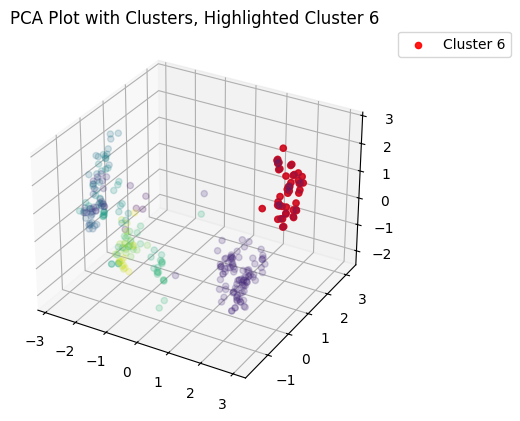

In [56]:
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Assume morgan_fingerprints and clusters_morgan are defined

# Apply PCA to reduce dimensionality
pca = PCA(n_components=6)
pca_result = pca.fit_transform(morgan_fingerprints)

# Create a DataFrame for visualization
df_pca = pd.DataFrame({'PCA1': pca_result[:, 0], 'PCA2': pca_result[:, 1], 'PCA3': pca_result[:, 2], 'Cluster': clusters_morgan})

# Plot the PCA in 3D
ax = plt.axes(projection='3d')
ax.scatter3D(df_pca['PCA1'], df_pca['PCA2'], df_pca['PCA3'], c=df_pca['Cluster'], cmap='viridis', alpha=0.2)

# Filter the DataFrame to include only cluster 5
selected_cluster = 6
df_cluster_spec = df_pca[df_pca['Cluster'] == selected_cluster]

# Plot only the values for cluster 5 with a different color
ax.scatter3D(df_cluster_spec['PCA1'], df_cluster_spec['PCA2'], df_cluster_spec['PCA3'], c='red', label=f'Cluster {selected_cluster}', alpha=0.9)

# Move the legend to the right of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.title(f'PCA Plot with Clusters, Highlighted Cluster {selected_cluster}')
plt.show()


Length of cluster: 49
Cluster 6 representative molecule:


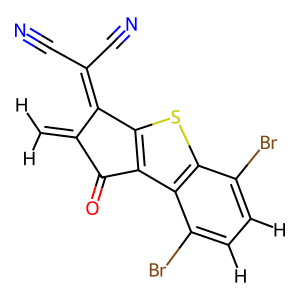

Top 1 Substructure (Frequency: 47 molecules):


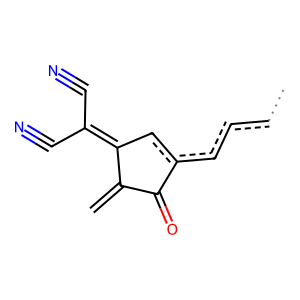

Top 2 Substructure (Frequency: 2 molecules):


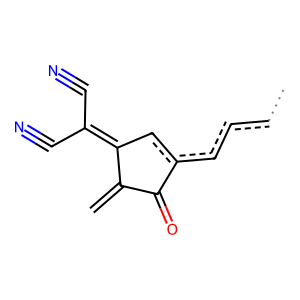

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display, HTML
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS
from rdkit import Chem
from collections import Counter


# Specify the cluster you want to focus on
cluster_to_focus = 6

#length of cluster
print('Length of cluster:', len([i for i, cluster_id in enumerate(clusters_morgan) if cluster_id == cluster_to_focus]))
print(f"Cluster {cluster_to_focus} representative molecule:")

# Find common substructure for the specified cluster 
representative_molecules = [X_frag_mol[i] for i, cluster_id in enumerate(clusters_morgan) if cluster_id == cluster_to_focus]
cluster_smiles = [Chem.MolToSmiles(X_frag_mol[j]) for j, cluster_id in enumerate(clusters_morgan) if cluster_id == cluster_to_focus]

# Display one molecule from the cluster
img = Draw.MolToImage(representative_molecules[0])
display(img)

# Generate common substructures for each molecule in the cluster
common_substructures = []
for smiles in cluster_smiles:
    mol = Chem.MolFromSmiles(smiles)
    mcs = rdFMCS.FindMCS([mol] + representative_molecules)
    common_substructure = Chem.MolFromSmarts(mcs.smartsString)
    common_substructures.append(common_substructure)

# Check if there's only one molecule in the cluster
if len(representative_molecules) < 2:
    print(f"Cluster {cluster_to_focus}: Not enough molecules for comparison.")
else:
    # Count the occurrences of each substructure
    substructure_counts = Counter([Chem.MolToSmarts(sub) for sub in common_substructures])

    # Rank substructures based on frequency
    ranked_substructures = sorted(substructure_counts.items(), key=lambda x: x[1], reverse=True)

    # Display the top N substructures and their occurrences
    top_n = min(3, len(ranked_substructures))  # Choose the smaller of 3 and the actual number of substructures
    for i, (substructure, count) in enumerate(ranked_substructures[:top_n]):
        print(f"Top {i + 1} Substructure (Frequency: {count} molecules):")
        img = Draw.MolToImage(Chem.MolFromSmarts(substructure))
        display(img)


In [58]:
import torch

#load dataset
dataset_path = "/rds/general/user/cb1319/home/GEOM3D/Geom3D/performance_eval_test/80Kdataset.pt"
dataset = torch.load(dataset_path)

# Print basic information about the dataset, like the first few rows
print("Dataset columns:", dataset[0].keys())

#Maka a list the InChiKeys present in Morgan cluster
morgan_keys = {}
for i in range(len(clusters_morgan)):
    morgan_keys[X_InChIKey[i]] = clusters_morgan[i]

#make a table of the different InChiKeys and their cluster, naming both the columns
morgan_keys = pd.DataFrame(morgan_keys.items(), columns=['InChIKey', 'Cluster'])
morgan_keys


Dataset columns: ['x', 'InChIKey', 'positions', 'y']


,InChIKey,Cluster
0,ULRLMMWHCRPTDR-UHFFFAOYSA-N,11
1,KYORXLIHDAZXPK-UHFFFAOYSA-N,6
2,AMGZARGPNNDZNG-UHFFFAOYSA-N,48
3,UVCFYBOLMFIWGF-FPYGCLRLSA-N,7
4,PQZAHLJJGPAGBD-OQFOIZHKSA-N,7
...,...,...
305,MRBCQJMEGDDUNN-WMZJFQQLSA-N,7
306,ITWOUVVCPPUABP-WCIBSUBMSA-N,7
307,BNVUEFDNDBLDLM-UHFFFAOYSA-N,34
308,BBVSASGXSWONDF-UHFFFAOYSA-N,6


In [59]:
test_cluster = 6

oligomer_has_frag_in_cluster_keys = []

# Columns to check
columns_to_check = [f'InChIKey_{i}' for i in range(6)]

# Iterate through the keys in morgan_keys['Cluster']
for key in morgan_keys['InChIKey'][morgan_keys['Cluster'] == test_cluster]:
    # Initialize a list to store associated df_total['InChIKey'] values
    associated_keys = []
    # Iterate through the columns to check
    for column in columns_to_check:
        # Check if the key is present in the current column
        if key in df_total[column].values:
            # Append the associated df_total['InChIKey'] values to the list
            associated_keys.extend(df_total['InChIKey'][df_total[column] == key].values)
    # If any associated keys were found, append them to the oligomer_has_frag_in_cluster_keys list
    if associated_keys:
        oligomer_has_frag_in_cluster_keys.extend(associated_keys)
    else:
        print('no')


#how many oligomer_has_frag_in_cluster_keys are in the dataset and remove duplicates
oligomer_has_frag_in_cluster_keys = list(set(oligomer_has_frag_in_cluster_keys))

#make a list of the InChiKeys in the dataset
dataset_keys = [dataset[i]['InChIKey'] for i in range(len(dataset))]

#make a list of the InChiKeys in the dataset that are in the cluster
dataset_keys_in_cluster = []
for key in dataset_keys:
    if key in oligomer_has_frag_in_cluster_keys:
        dataset_keys_in_cluster.append(key)

print('Number of Oligomers that have a fragment in the cluster:', len(dataset_keys_in_cluster))


Number of Oligomers that have a fragment in the cluster: 26125


In [181]:
import stk
import pymongo
import numpy as np
import os
import pandas as pd
import torch.optim as optim
import torch
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Batch
import torch.nn.functional as Functional
from lightning.pytorch.callbacks import ModelCheckpoint
from pathlib import Path
from geom3d.utils import database_utils
from geom3d.dataloaders import dataloaders_GemNet
from geom3d.dataloaders.dataloaders_GemNet import DataLoaderGemNet
from geom3d.dataloaders.dataloaders_GemNetLEP import DataLoaderGemNetLEP
from geom3d.dataloaders.dataloaders_GemNetPeriodicCrystal import DataLoaderGemNetPeriodicCrystal
import importlib
from torch_cluster import radius_graph

len(dataset)
# Call the fragment_scaffold_split function to get test set InChIKeys
cluster_keys = dataset_keys_in_cluster
print("Number of test samples:", len(cluster_keys))

# Get the test set indices based on InChIKeys
test_idx = [i for i, data in enumerate(dataset) if data['InChIKey'] in cluster_keys]
print("Number of test samples:", len(test_idx))
# Get the remaining indices for train and val set
remaining_idx = [i for i in range(len(dataset)) if i not in test_idx]
# Randomly shuffle the remaining indices
np.random.shuffle(remaining_idx)
# Split the remaining indices into train and val based on the specified ratio
split_idx = int(len(remaining_idx) * (1 - 0.15))
train_idx = remaining_idx[:split_idx]
valid_idx = remaining_idx[split_idx:]

assert len(set(train_idx).intersection(set(valid_idx))) == 0
assert len(set(valid_idx).intersection(set(test_idx))) == 0
assert len(train_idx) + len(valid_idx) + len(test_idx) == 80000

train_dataset = [dataset[x] for x in train_idx]
valid_dataset = [dataset[x] for x in valid_idx]
test_dataset = [dataset[x] for x in test_idx]

print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(valid_dataset))
print("Number of test samples:", len(test_dataset))

# Set dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=1,
)
val_loader = DataLoader(
    valid_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=1
)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=1,
)



Number of test samples: 7548
Number of test samples: 7548
Number of training samples: 61584
Number of validation samples: 10868
Number of test samples: 7548


In [2]:
from geom3d.train_models import *
import torch
import copy

from geom3d.utils import fragment_scaffold_split
from geom3d.utils import database_utils


import os
os.chdir('/rds/general/user/cb1319/home/GEOM3D/Geom3D/')
config_dir = os.getcwd()+"/performance_eval_test/SchNet_IP_80000"
config = read_config(config_dir)

dataset_path = "/rds/general/user/cb1319/home/GEOM3D/Geom3D/performance_eval_test/80Kdataset.pt"
dataset = torch.load(dataset_path)


config loaded from /rds/general/user/cb1319/home/GEOM3D/Geom3D/performance_eval_test/SchNet_IP_80000


In [54]:
import importlib
from geom3d.utils import fragment_scaffold_split
from geom3d.utils.fragment_scaffold_split import *

importlib.reload(fragment_scaffold_split)

cluster_keys = fragment_scaffold_splitter(dataset, config)

print("Number of test samples:", len(cluster_keys))

Loading dataset indices from /rds/general/user/cb1319/home/GEOM3D/Geom3D/performance_eval_test/datasplit_80000_fragment_scaffold_threshold_0.55.csv
Chosen cluster: 1
Number of molecules in the cluster: 149


analysing how many oliogomers have chosen fragments: 100%|██████████| 149/149 [00:06<00:00, 21.64it/s]


Number of Oligomers that have a fragment in the cluster: 46065
Number of test samples: 46065


In [15]:
%matplotlib inline

In [69]:

# read the datafra me from this file
df = pd.read_csv("/rds/general/user/cb1319/home/GEOM3D/Geom3D/performance_eval_test/datasplit_80000_fragment_scaffold_threshold_0.55.csv")

# see the first few rows of the dataframe
df.head()

,InChIKey,Cluster
0,ULRLMMWHCRPTDR-UHFFFAOYSA-N,41
1,KYORXLIHDAZXPK-UHFFFAOYSA-N,2
2,AMGZARGPNNDZNG-UHFFFAOYSA-N,10
3,UVCFYBOLMFIWGF-FPYGCLRLSA-N,1
4,PQZAHLJJGPAGBD-OQFOIZHKSA-N,1


In [17]:
%matplotlib inline

Index(['InChIKey', 'Morgan_Fingerprint'], dtype='object')


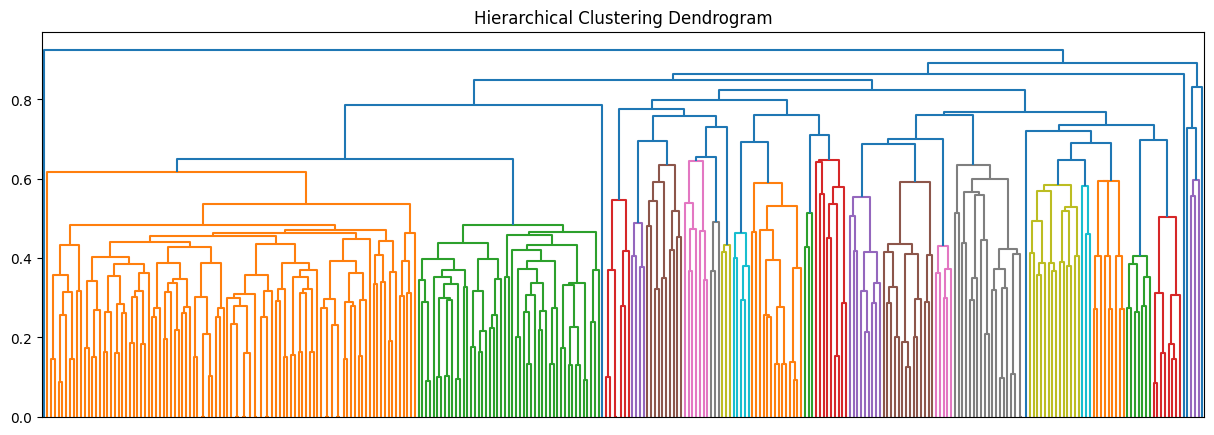

In [45]:
import importlib
from geom3d.utils import fragment_scaffold_split
from geom3d.utils.fragment_scaffold_split import *

importlib.reload(fragment_scaffold_split)

plot_dendrograms(dataset, config)

In [46]:
import importlib
from geom3d.utils import fragment_scaffold_split
from geom3d.utils.fragment_scaffold_split import *

importlib.reload(fragment_scaffold_split)

cluster_analysis(dataset, config, threshold = 0.80)

Index(['InChIKey', 'Morgan_Fingerprint'], dtype='object')
Clustering dataset with threshold 0.8
Index(['InChIKey', 'Morgan_Fingerprint', 'Cluster'], dtype='object')
Number of molecules in each cluster for morgan fp: {1: 149, 2: 65, 3: 89, 4: 1, 5: 4, 6: 1, 7: 1}
Dataset cluster assignments saved to /rds/general/user/cb1319/home/GEOM3D/Geom3D/performance_eval_test/datasplit_80000_fragment_scaffold_threshold_0.8.csv


,InChIKey,Morgan_Fingerprint,Cluster
0,ULRLMMWHCRPTDR-UHFFFAOYSA-N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
1,KYORXLIHDAZXPK-UHFFFAOYSA-N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
2,AMGZARGPNNDZNG-UHFFFAOYSA-N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2
3,UVCFYBOLMFIWGF-FPYGCLRLSA-N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
4,PQZAHLJJGPAGBD-OQFOIZHKSA-N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
...,...,...,...
305,MRBCQJMEGDDUNN-WMZJFQQLSA-N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
306,ITWOUVVCPPUABP-WCIBSUBMSA-N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1
307,BNVUEFDNDBLDLM-UHFFFAOYSA-N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2
308,BBVSASGXSWONDF-UHFFFAOYSA-N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


Index(['InChIKey', 'Morgan_Fingerprint'], dtype='object')
Clustering dataset with threshold 0.8
Index(['InChIKey', 'Morgan_Fingerprint', 'Cluster'], dtype='object')
Number of molecules in each cluster for morgan fp: {1: 149, 2: 65, 3: 89, 4: 1, 5: 4, 6: 1, 7: 1}
Dataset cluster assignments saved to /rds/general/user/cb1319/home/GEOM3D/Geom3D/performance_eval_test/datasplit_80000_fragment_scaffold_threshold_0.8.csv


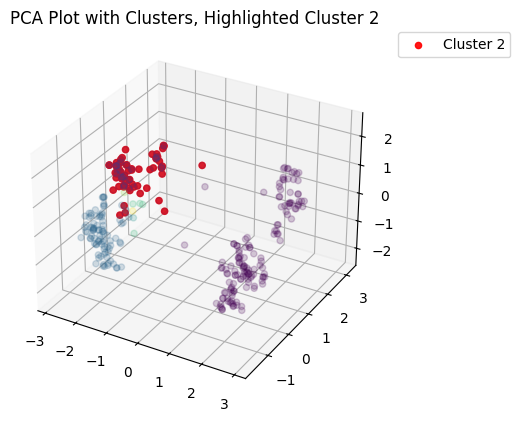

In [49]:
import importlib
from geom3d.utils import fragment_scaffold_split
from geom3d.utils.fragment_scaffold_split import *

importlib.reload(fragment_scaffold_split)

pca_plot(dataset, config, selected_cluster = 2, threshold = 0.80)

Loading dataset indices from /rds/general/user/cb1319/home/GEOM3D/Geom3D/performance_eval_test/datasplit_80000_fragment_scaffold_threshold_0.8.csv
Length of cluster: 65
Cluster 2 representative molecule:


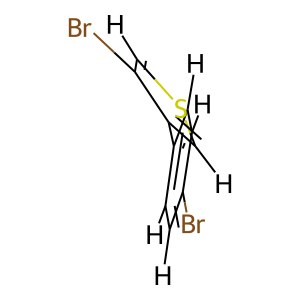

Top 1 Substructure (Frequency: 60 molecules):


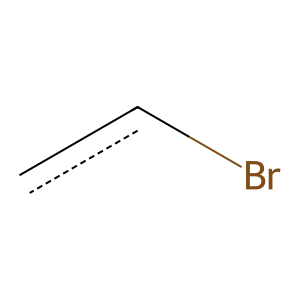

Top 2 Substructure (Frequency: 5 molecules):


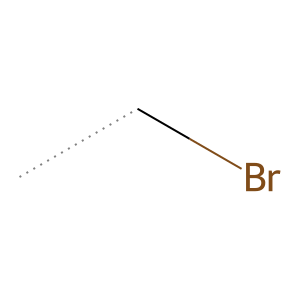

In [52]:
import importlib
from geom3d.utils import fragment_scaffold_split
from geom3d.utils.fragment_scaffold_split import *

importlib.reload(fragment_scaffold_split)

substructure_analysis(dataset, config, selected_cluster=2, threshold=0.8)